In [1]:
import math

import librosa
import pandas
import numpy

from matplotlib import pyplot as plt
import librosa.display


In [2]:

samplerate = 16000
time_resolution = 0.050

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_fft = next_power_of_2(hop_length)

print(hop_length, n_fft)

800 1024


In [3]:
def load_annotations(path):
    df = pandas.read_csv(path, header=None)
    df.columns = ['start', 'end', 'event']
    
    # drop duplicates
    df = df[~df['start'].duplicated()]
    
    df['duration'] = df['end'] - df['start']
    df = df.sort_values('start')
    
    return df

annotations_path = 'data/annotations.csv'
annotations = load_annotations(annotations_path)
annotations.head(1)

,start,end,event,duration
0,7.055938,7.220668,yes,0.16473


In [4]:
annotations.tail(1)

,start,end,event,duration
124,299.328251,299.438071,yes,0.10982


In [5]:
annotations.event.value_counts()

yes    120
Name: event, dtype: int64

<AxesSubplot:>

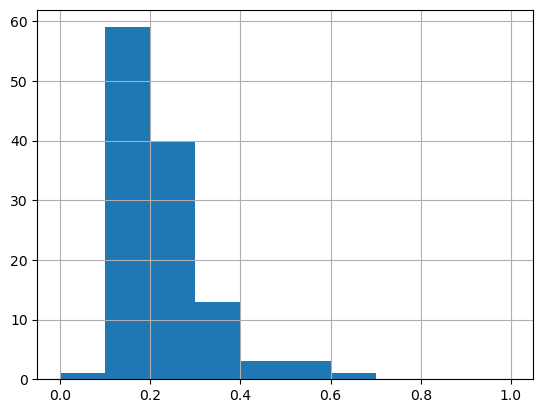

In [6]:
annotations.duration.hist(width=0.10, range=(0, 1.0))

<AxesSubplot:>

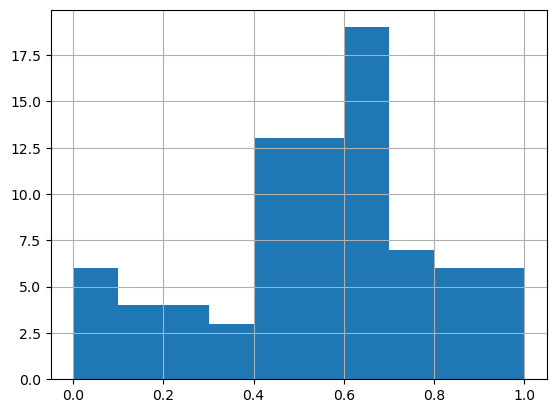

In [7]:
(annotations['start'] - (annotations['end'].shift(1))).hist(width=0.1, range=(0, 1.0))


In [8]:
def load_spectrogram(path, sr=16000, n_mels=32, n_fft=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    db = librosa.power_to_db(S, ref=0.0)
    
    return db

audio_path = 'data/source2.wav'
spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
spec.shape

(32, 6001)

In [9]:
def spectrogram_labels(events, spec, time_resolution):
    """
    Create a continious vector for the event labels that matches the time format of our spectrogram
    
    Assumes that no annotated event means nothing occurred.
    """

    freq = pandas.Timedelta(seconds=time_resolution)
    
    # Create empty covering entire spectrogram
    spec_duration = spec.shape[1] * time_resolution
    ix = pandas.timedelta_range(start=pandas.Timedelta(seconds=0.0),
                    end=pandas.Timedelta(seconds=spec_duration),
                    freq=freq,
                    closed='left',
    )
    ix.name = 'time'
    df = pandas.DataFrame({}, index=ix)
    assert len(df) == spec.shape[1], (len(df), spec.shape[1])
    df["event"] = 0
    
    # fill in event data
    for start, end in zip(events['start'], events['end']):
        s = pandas.Timedelta(start, unit='s')
        e = pandas.Timedelta(end, unit='s')
        #
        e = s + pandas.Timedelta(0.100, unit='s') # XXX: trying to focus just on onsets
        match = df.loc[s:e]
        df.loc[s:e, "event"] = 1
    
    return df

l = spectrogram_labels(annotations[annotations.event == 'yes'], spec, time_resolution)
l.event.value_counts()

0    5761
1     240
Name: event, dtype: int64

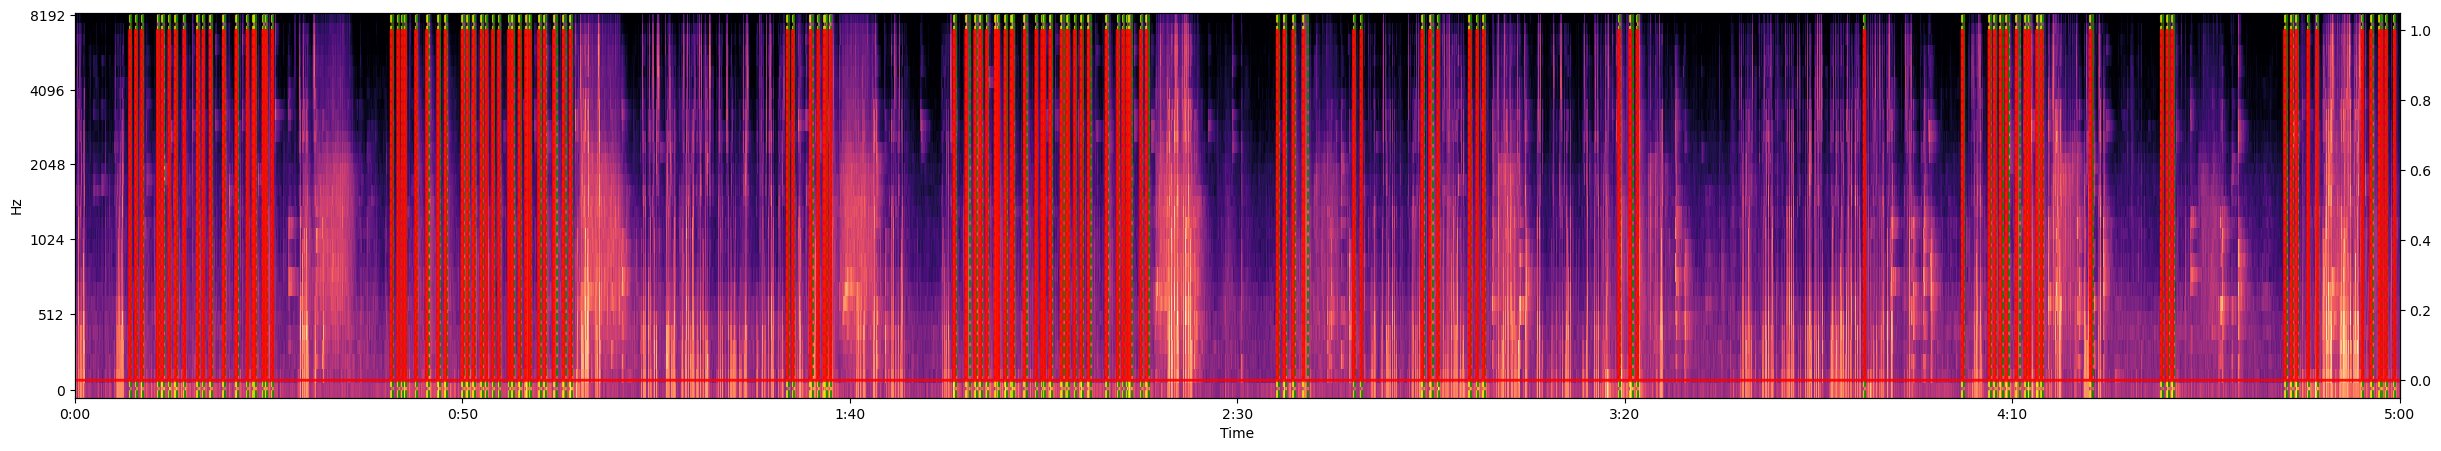

In [190]:
def soundlevel_spectrogram(spec):
    n_mels = spec.shape[0]
    
    freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=0.001, fmax=samplerate/2.)
    weights = librosa.A_weighting(freqs)
    weighted = spec - numpy.expand_dims(weights, axis=-1)
    
    #energy = librosa.db_to_power(weighted)
    #s = librosa.power_to_db(energy.sum(axis=0) / n_mels)
    s = weighted.mean(axis=0)
    return s
    
    
def plot_spectrogram(ax, spec, events=None, label_activations=None, predictions=None, plot_soundlevels=None):
    events_lw = 1.5
    
    # Plot spectrogram
    librosa.display.specshow(ax=ax, data=spec, hop_length=hop_length, x_axis='time', y_axis='mel', sr=samplerate)

    # Plot events
    if events is not None:
        for start, end in zip(events.start, events.end):
            ax.axvspan(start, end, alpha=0.2, color='yellow')
            ax.axvline(start, alpha=0.7, color='yellow', ls='--', lw=events_lw)
            ax.axvline(end, alpha=0.8, color='green', ls='--', lw=events_lw)

    label_ax = ax.twinx()
    
    # Plot soundlevel
    if plot_soundlevels:
        sl = soundlevel_spectrogram(spec)
        sl_norm = sl / numpy.max(sl)
        t = librosa.frames_to_time(numpy.arange(spec.shape[1]), hop_length=hop_length, sr=samplerate)
        label_ax.plot(t, sl_norm)
    
    # Plot event activations
    if label_activations is not None:
        a = label_activations.reset_index()
        a['time'] = a['time'].dt.total_seconds()
        label_ax.step(a['time'], a['event'], color='red', alpha=0.9, lw=2.0)

    # Plot model predictions
    if predictions is not None:
        p = predictions.reset_index()
        p['time'] = p['time'].dt.total_seconds()
        label_ax.step(p['time'], p['probability'], color='blue', alpha=0.9, lw=3.0)
            
        label_ax.axhline(0.5, ls='--', color='black', alpha=0.5, lw=2.0)
            
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
#ax.set_xlim(10, 15)

(0.0, 15.0)

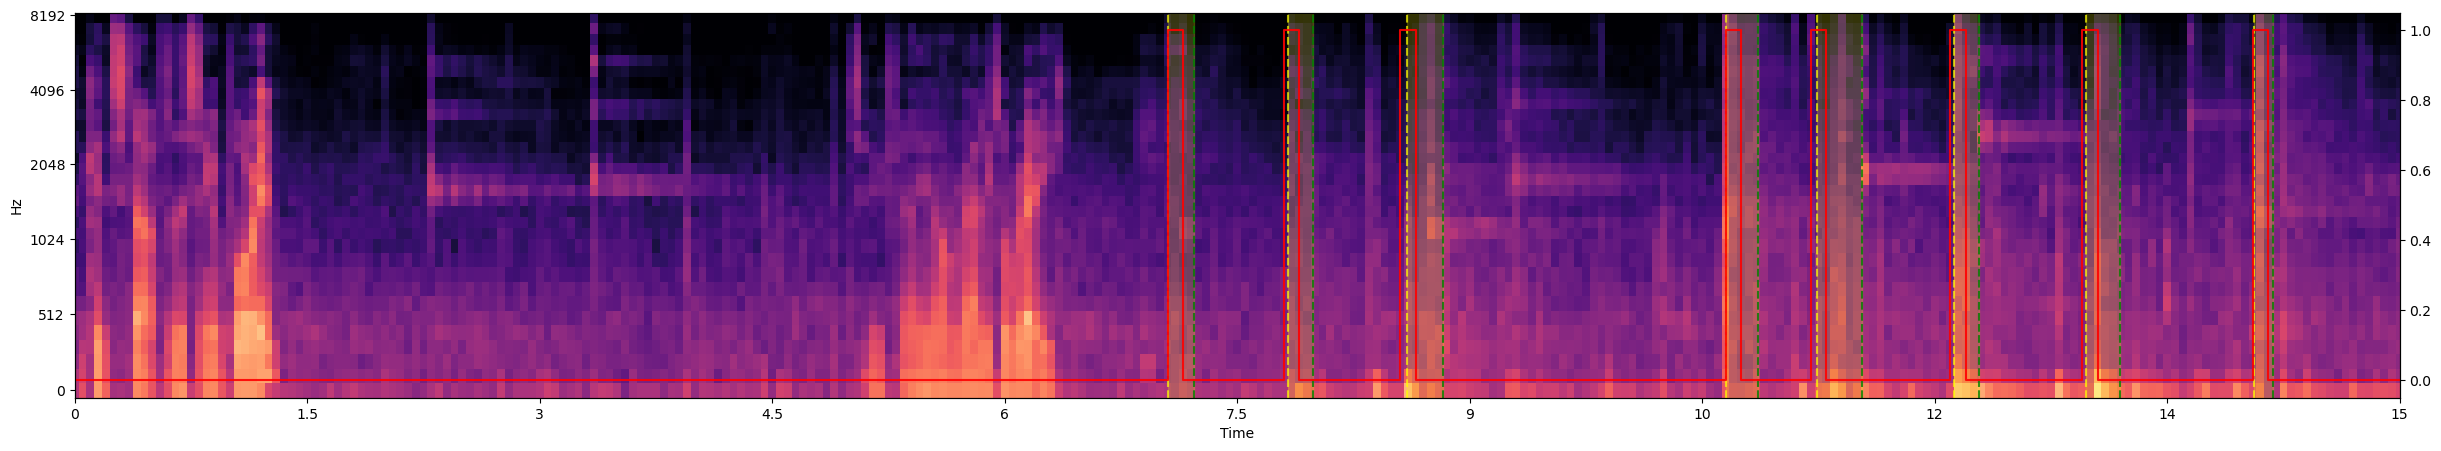

In [179]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(0, 15)
#ax.set_xlim(110, 120)

(15.0, 30.0)

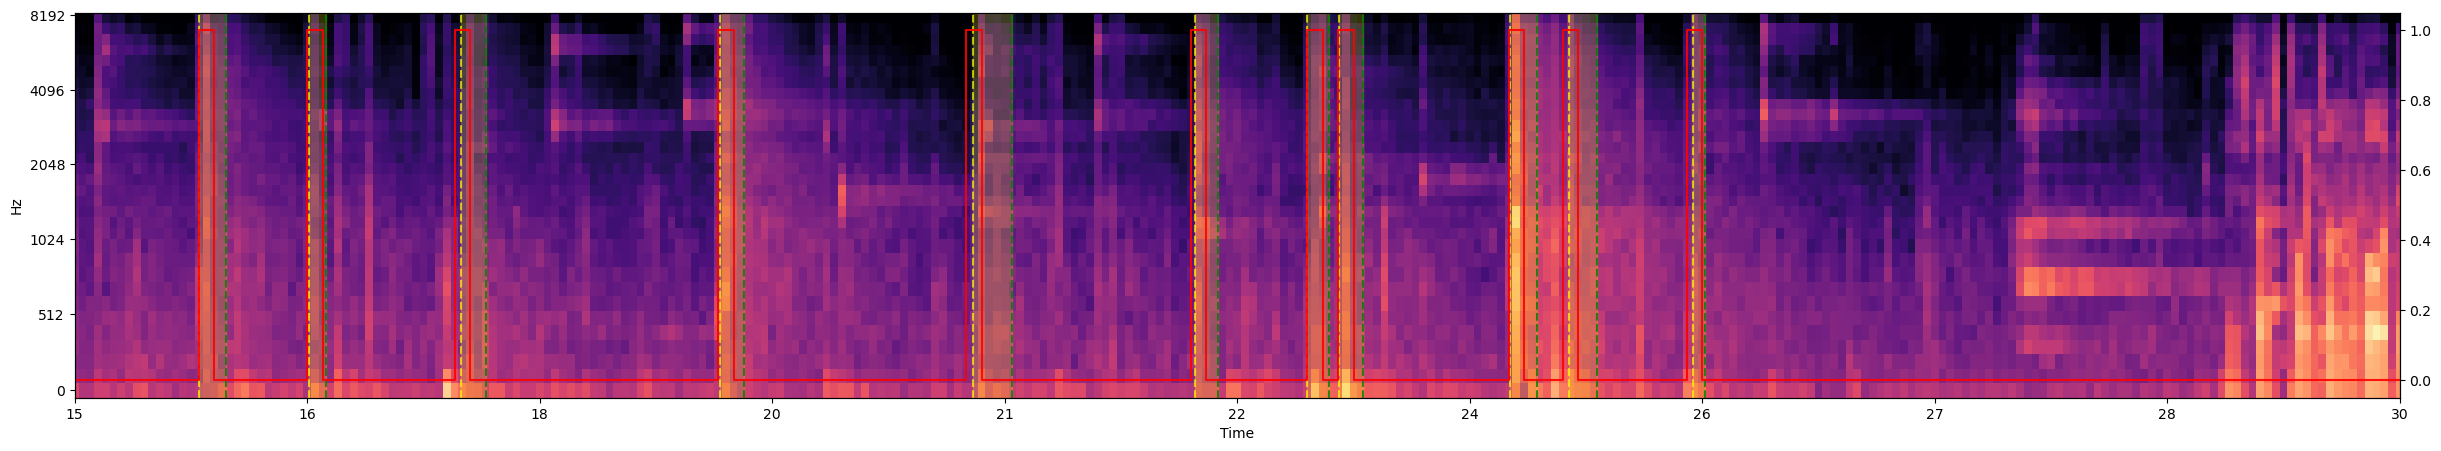

In [180]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(15, 30)


In [261]:
window_duration = 0.401
window_length = int(window_duration / time_resolution)
window_length

8

In [262]:
# extract time-windows for spectrograms and labels

def compute_windows(arr, frames, pad_value=0.0, overlap=0.5, step=None):
    if step is None:
        step = int(frames * (1-overlap))
        
    windows = []
    
    width, length = arr.shape
    
    for start_idx in range(0, length, step):
        end_idx = min(start_idx + frames, length)

        # create emmpty
        win = numpy.full((width, frames), pad_value, dtype=float)
        # fill with data
        win[:, 0:end_idx-start_idx] = arr[:,start_idx:end_idx]

        windows.append(win)

    return windows

windows = pandas.DataFrame({
    'spectrogram': compute_windows(spec, frames=window_length, overlap=0.8),
    'labels': compute_windows(l.values.T, frames=window_length, overlap=0.8),
})
windows.shape

(6001, 2)

In [263]:

def compute_features(spec):
    sl = soundlevel_spectrogram(spec)
    sl_diff = numpy.diff(sl, n=1)
    f = pandas.Series({
        'db_max': sl.max(),
        'db_diff_max': sl_diff.max(),
        'db_rel_max': sl.max() - numpy.min(sl),
    })
    return f
    

ff = windows.spectrogram.apply(compute_features)
ff = pandas.merge(ff, windows, right_index=True, left_index=True)
ff['event'] = ff.labels.apply(lambda labels: numpy.any(labels, axis=-1)).astype(int)
ff.head()

,db_max,db_diff_max,db_rel_max,spectrogram,labels,event
0,73.412245,12.357576,17.228673,"[[75.1259536743164, 85.1960220336914, 73.44403...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
1,80.091015,13.463694,22.699570,"[[85.1960220336914, 73.44403076171875, 99.1505...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
2,80.091015,13.463694,18.734561,"[[73.44403076171875, 99.15057373046875, 89.515...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
3,80.091015,13.463694,18.734561,"[[99.15057373046875, 89.51517486572266, 72.664...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
4,80.091015,13.463694,18.734561,"[[89.51517486572266, 72.66426086425781, 73.641...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0


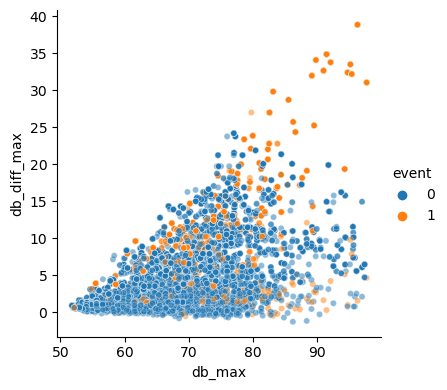

In [264]:
import seaborn
seaborn.relplot(data=ff,
                x='db_max',
                y='db_diff_max',
                hue='event',
                #col='event',
                s=20,
                height=4,
                aspect=1,
                alpha=0.5,
               ) 

""


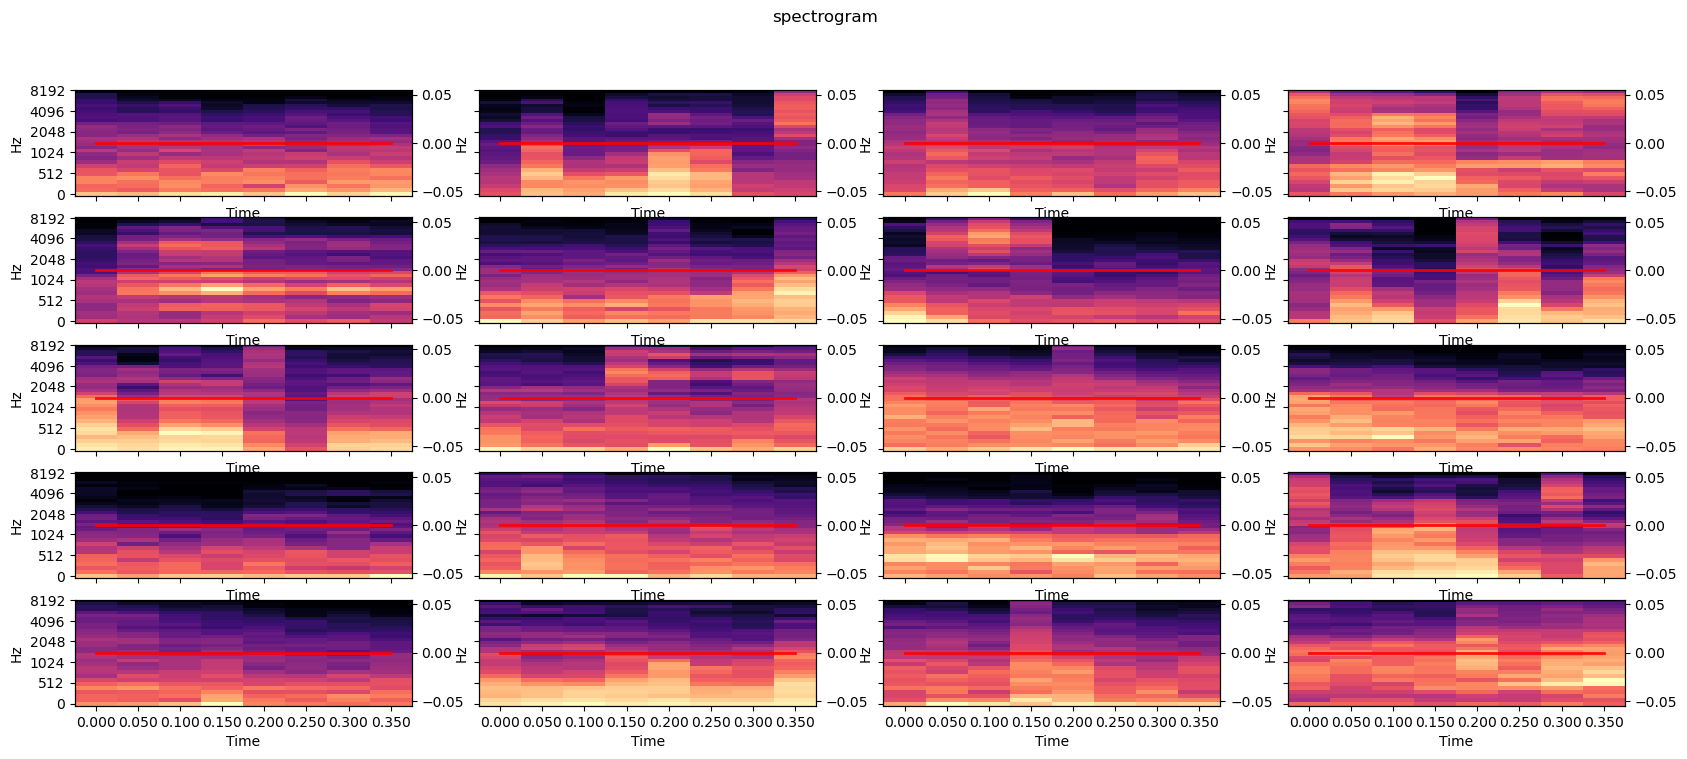

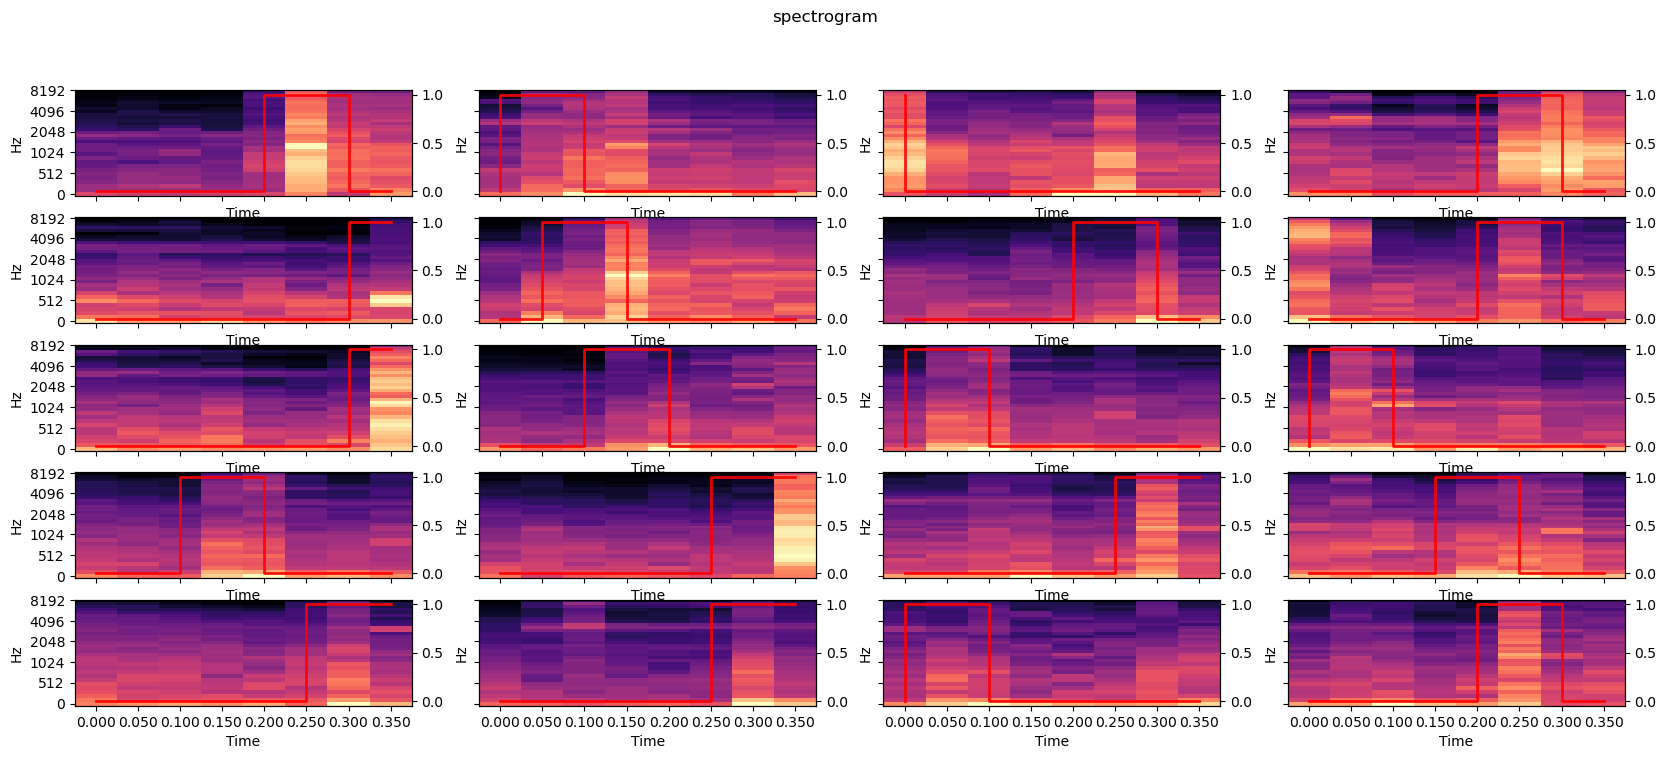

In [265]:
def plot_windows(wins, col_wrap=None, height=4, aspect=1):
    specs = wins.spectrogram
    
    nrow = 1
    ncol = len(specs)
    if col_wrap is not None:
        nrow = int(numpy.ceil(ncol / col_wrap))
        ncol = col_wrap

    fig_height = height * nrow
    fig_width = height * aspect * ncol
    fig, axs = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(fig_width, fig_height))
    axs = numpy.array(axs).flatten()
    
    fig.suptitle(specs.name)
    for ax, s, l in zip(axs, specs, wins.labels):
    
        l = numpy.squeeze(l)
        ll = pandas.DataFrame({
            'event': l,
            'time': pandas.to_timedelta(numpy.arange(l.shape[0])*hop_length/samplerate, unit='s'),
        })

        plot_spectrogram(ax, s, label_activations=ll)


ff.groupby('event').sample(n=20).groupby('event').apply(plot_windows, col_wrap=5, aspect=2, height=2)

In [266]:
# split windows into train, val, test
# note: random splitting has data leak. Much better to split by match!

def dataset_split_sequentially(data, val_size=0.25, test_size=0.25, random_state=3, column='split'):
    """
    Split DataFrame into 3 non-overlapping parts: train,val,test
    with specified proportions
    
    Returns a new DataFrame with the rows marked by the assigned split in @column
    """
    train_size = (1.0 - val_size - test_size)

    train_stop = int(len(data) * train_size)
    val_stop = train_stop + int(len(data)*val_size)
    
    train_idx = data.index[0:train_stop]
    val_idx = data.index[train_stop:val_stop]
    test_idx = data.index[val_stop:-1]
    
    data = data.copy()
    data.loc[train_idx, column] = 'train'
    data.loc[val_idx, column] = 'val'
    data.loc[test_idx, column] = 'test'
    
    return data

dataset = dataset_split_sequentially(windows, val_size=0.15, test_size=0.15)
dataset.split.value_counts()

train    4200
val       900
test      900
Name: split, dtype: int64

In [267]:
# build simple CNN model

import tensorflow.keras

def build_model(input_shape, dropout=0.5, lr=0.01):
    
    from tensorflow.keras.layers import Convolution2D, SeparableConv2D, GlobalMaxPooling2D, Flatten, Dense, Activation, Dropout
    
    model = tensorflow.keras.Sequential([
        Convolution2D(8, 5, strides=(3,2), padding='same', input_shape=input_shape),
        SeparableConv2D(16, 3, strides=(2,3), padding='valid'),
        #SeparableConv2D(16, 2, strides=(1,3), padding='valid'),
        #GlobalMaxPooling2D(),
        Flatten(),
        Dense(16),
        Dropout(dropout),
        Activation('relu'),
        Dropout(dropout),
        Dense(16),
        Activation('relu'),
        Dropout(dropout),
        Dense(16),
        Activation('relu'),
        Dense(1, activation='sigmoid'),
    ])
   
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    # Focal loss tends to be a bit better for imbalanced data
    #loss = tensorflow.keras.losses.BinaryFocalCrossentropy()
    
    loss = tensorflow.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(32, window_length, 1))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 11, 4, 8)          208       
                                                                 
 separable_conv2d_22 (Separa  (None, 5, 1, 16)         216       
 bleConv2D)                                                      
                                                                 
 flatten_20 (Flatten)        (None, 80)                0         
                                                                 
 dense_88 (Dense)            (None, 16)                1296      
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 activation_66 (Activation)  (None, 16)                0         
                                                     

In [268]:

epochs = 200
batch_size = 1*64

Xm = numpy.expand_dims(numpy.mean(numpy.concatenate([s.T for s in dataset.spectrogram]), axis=0), -1)
print(Xm.shape)

def get_XY(split):
    d = dataset[dataset.split == split]
    X = numpy.expand_dims(numpy.stack([s-Xm for s in d.spectrogram]), -1)
    
    # spectral subtraction

    #X = X - Xm
    
    Y = numpy.stack(d.labels)
    Y = numpy.any(Y, axis=-1)
    
    #Y = numpy.count_nonzero(Y, axis=-1) >= 2
    #print(X.shape)
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_pr_auc', patience=10)

def compute_class_weights(y_train):
    from sklearn.utils import class_weight
    y_train = numpy.squeeze(y_train).astype(int)
    w = class_weight.compute_class_weight('balanced', classes=numpy.unique(y_train), y=y_train)
    w_dict = dict(zip(numpy.unique(y_train), w))
    return w_dict

class_weights = compute_class_weights(train[1])
    
model = build_model(input_shape=(32, window_length, 1), dropout=0.10, lr=5*0.001)
hist = model.fit(x=train[0], y=train[1],
          validation_data=val,
          epochs=epochs,
          batch_size=batch_size,
        callbacks=[early_stop],
             class_weight=class_weights,
)


(32, 1)
Epoch 1/200
66/66 [==============================] - 1s 5ms/step - loss: 0.7155 - pr_auc: 0.2486 - precision: 0.3007 - recall: 0.1060 - val_loss: 0.5646 - val_pr_auc: 0.1738 - val_precision: 0.2063 - val_recall: 0.3939
Epoch 2/200
66/66 [==============================] - 0s 2ms/step - loss: 0.6497 - pr_auc: 0.3120 - precision: 0.3307 - recall: 0.4106 - val_loss: 0.5945 - val_pr_auc: 0.1830 - val_precision: 0.1920 - val_recall: 0.6263
Epoch 3/200
66/66 [==============================] - 0s 2ms/step - loss: 0.6107 - pr_auc: 0.3538 - precision: 0.3650 - recall: 0.5882 - val_loss: 0.6100 - val_pr_auc: 0.1833 - val_precision: 0.1955 - val_recall: 0.7071
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.5891 - pr_auc: 0.3814 - precision: 0.3780 - recall: 0.6510 - val_loss: 0.6183 - val_pr_auc: 0.1898 - val_precision: 0.1935 - val_recall: 0.7172
Epoch 5/200
66/66 [==============================] - 0s 2ms/step - loss: 0.5689 - pr_auc: 0.3933 - precision: 0.3818

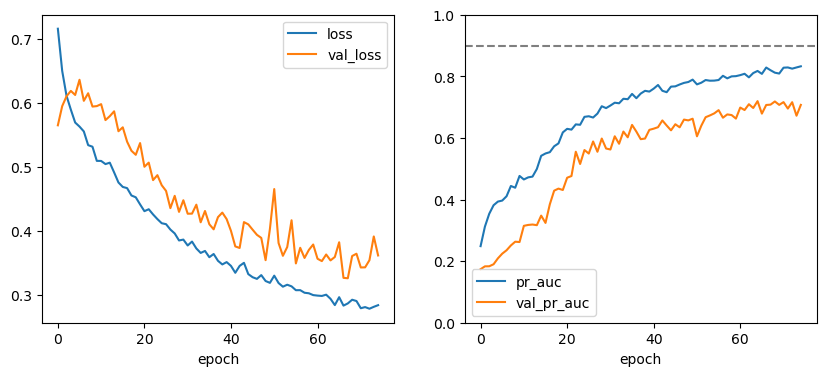

In [270]:
# Plot the scores over epochs
def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    history = pandas.DataFrame(hist.history)
    history.index.name = 'epoch'
    history.plot(ax=axs[0], y=['loss', 'val_loss'])
    history.plot(ax=axs[1], y=['pr_auc', 'val_pr_auc'])
    axs[1].set_ylim(0, 1.0)
    axs[1].axhline(0.9, ls='--', color='black', alpha=0.5)

    
plot_history(history)

In [271]:
test = get_XY(split='test')

results = pandas.DataFrame({
    'split': [ 'test', 'train', 'val' ],
})
def get_metric(split):
    X, Y = get_XY(split=split)
    r = model.evaluate(x=X, y=Y, return_dict=True)
    return pandas.Series(r)

e = results.split.apply(get_metric)
results = pandas.merge(results, e, right_index=True, left_index=True).set_index('split')
results


29/29 [==============================] - 0s 1ms/step - loss: 0.3614 - pr_auc: 0.7072 - precision: 0.4081 - recall: 0.9192        


,loss,pr_auc,precision,recall
split,,,,
test,0.302323,0.649738,0.536082,0.793893
train,0.253298,0.876999,0.669659,0.919852
val,0.361393,0.707240,0.408072,0.919192


29/29 [==============================] - 0s 746us/step


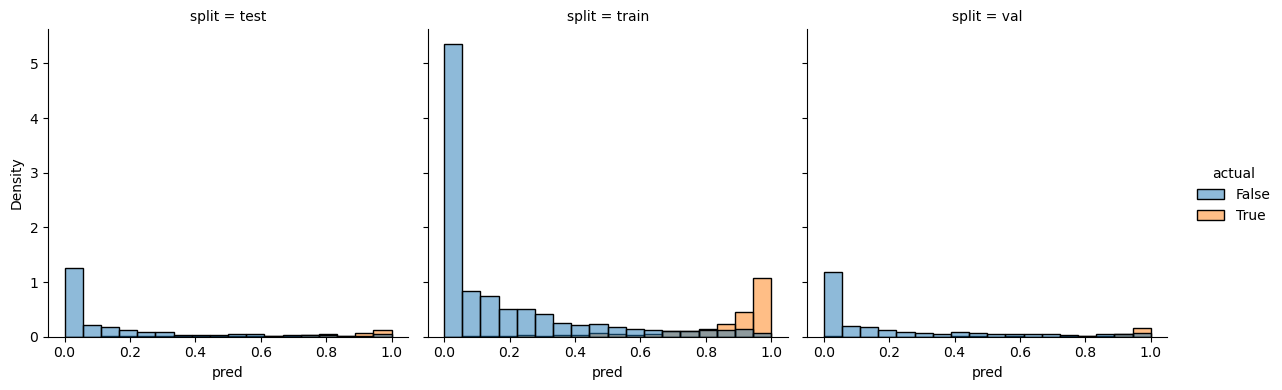

In [272]:
import seaborn

rr = []
for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = numpy.squeeze(Y)
    y_pred = numpy.squeeze(model.predict(X))

    r = pandas.DataFrame({
        'pred': y_pred,
        'actual': y_true,
        'split': split,
    })
    rr.append(r)

r = pandas.concat(rr, ignore_index=True)
seaborn.displot(kind='hist', data=r, x='pred', hue='actual', col='split', height=4, aspect=1, binrange=(0.0, 1.0), stat='density')

    

29/29 [==============================] - 0s 710us/step


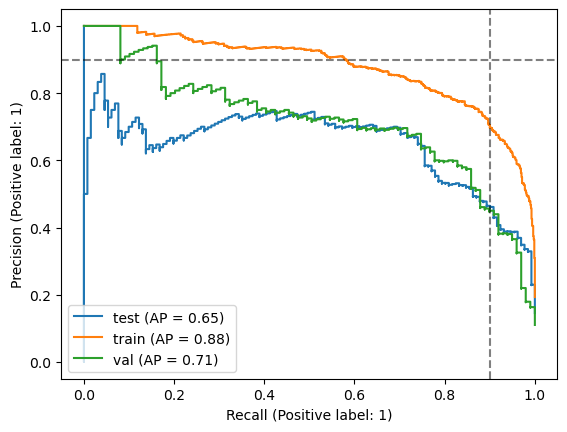

In [273]:
# Plot precision/recall trade-off

from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1)

for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = Y
    y_pred = model.predict(X)
    
    #pandas.Series(numpy.squeeze(y_pred)).hist()

    PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y_true, y_pred=y_pred, name=split)

ax.axhline(0.9, ls='--', color='black', alpha=0.5)
ax.axvline(0.9, ls='--', color='black', alpha=0.5)

188/188 [==============================] - 0s 596us/step
0 days 00:05:01.000625
(6001,) (6001,) 6001 None


(0.0, 25.0)

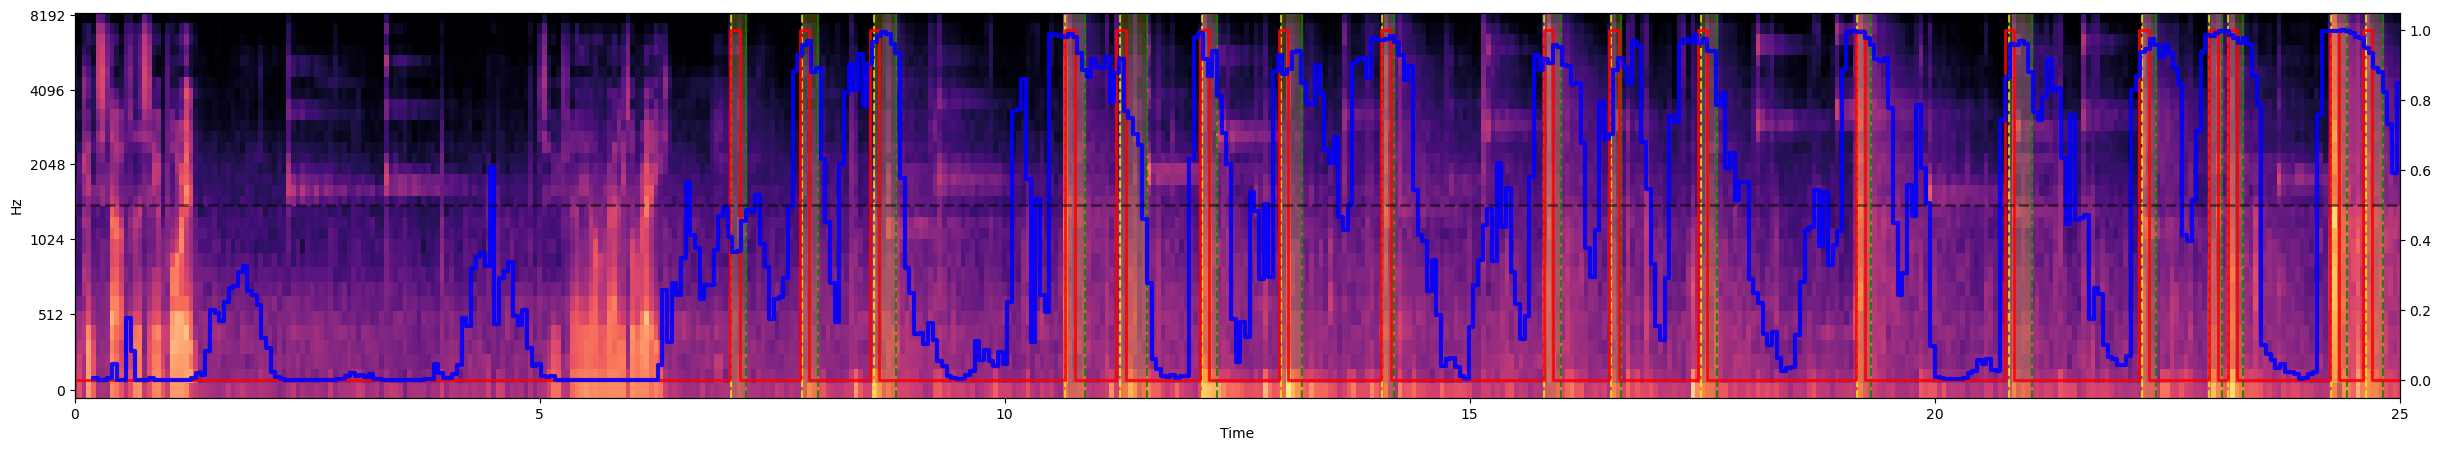

In [274]:

def predict_spectrogram(model, spec):
    
    wins = compute_windows(spec, frames=window_length, step=1)
    t = numpy.linspace(0.0, (spec.shape[1]/window_length)*window_duration, len(wins))
    X = numpy.expand_dims(numpy.stack( [ w-Xm for w in wins ]), -1)
    
    y = numpy.squeeze(model.predict(X))

    # shift predictions to middle of window
    t += (window_duration*0.5)
    
    t = pandas.to_timedelta(t, unit='s')
    
    print(t.shape, y.shape, len(wins), print(t[-1]))
    
    df = pandas.DataFrame({
        'time': t,
        'probability': y,
    })
    return df
    
predictions = predict_spectrogram(model, spec)
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)
ax.set_xlim(0, 25)



(30.0, 45.0)

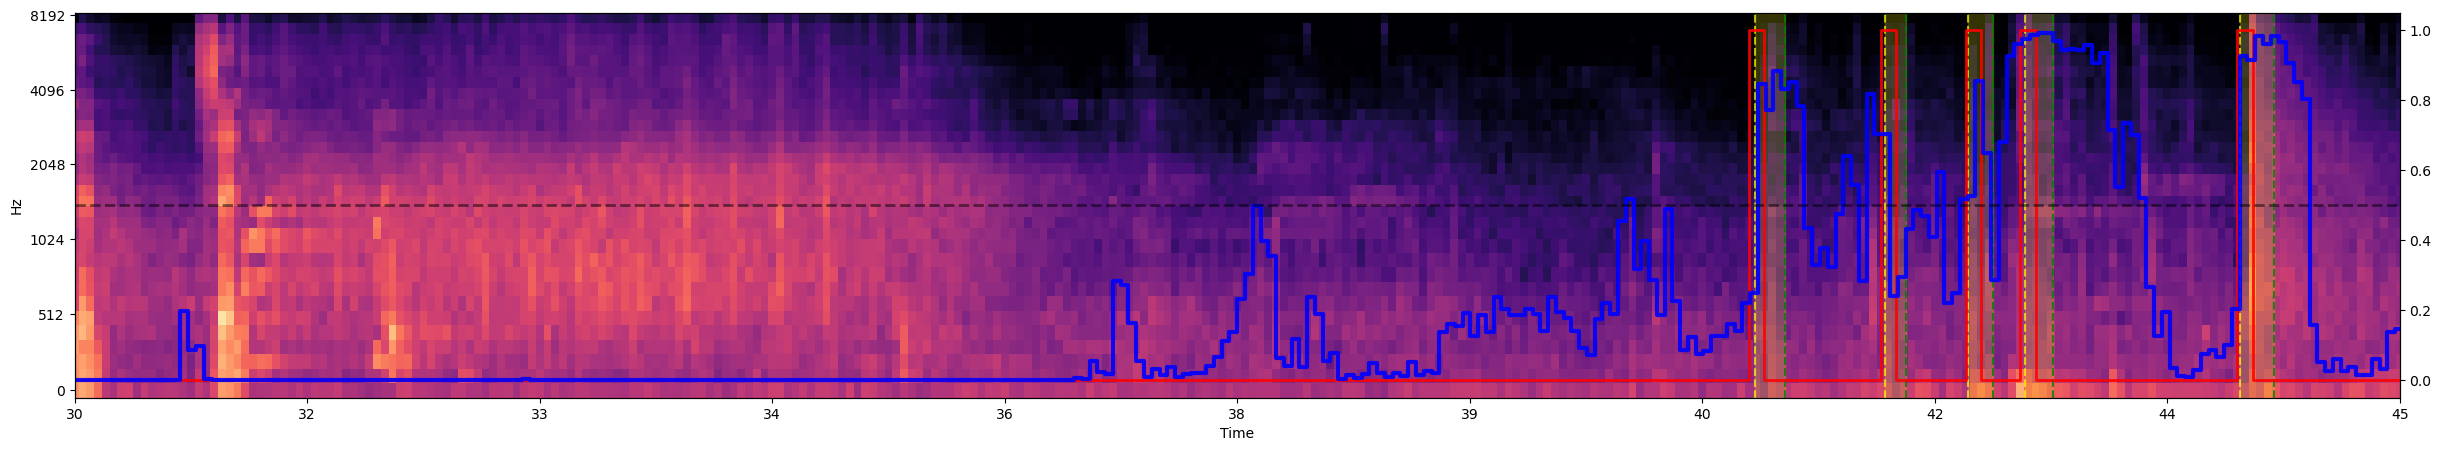

In [275]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)
ax.set_xlim(30, 45)